<a href="https://colab.research.google.com/github/Zoya-Fathima/Pythonprogramming/blob/master/timeseries_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib as plt

In [ ]:
def get_data():
  data_file = "/content/station.csv"
  f = open(data_file)
  data = f.read()
  f.close()
  lines = data.split('\n')
  header = lines[0].split(',')
  lines = lines[2:]
  temperatures=[]
  for line in lines:
    if line:
      linedata = line.split(',')
      linedata = linedata[1:13]
      for item in linedata:
        if item:
          temperatures.append(float(item))
  series = np.asarray(temperatures)
  time = np.arange(len(temperatures), dtype="float32")
  return time, series

In [ ]:
time, series = get_data()

In [ ]:
out = np.logical_not(series > 200)
series=series[out]
time=time[out]

In [ ]:
len(series)

657

In [ ]:
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std

In [ ]:
#device_name = tf.test.gpu_device_name()

In [ ]:
split_time = 390
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
window_size = 48
batch_size = 12
shuffle_buffer_size = 96

In [ ]:
def windowed_dataset(series, window_size,
batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1,
  drop_remainder=True)
  dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [ ]:
initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

In [ ]:
def model_forecast(model, series, window_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  # lamda function acts as a for loop in one line
  ds = ds.batch(12).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, kernel_initializer=initializer),
tf.keras.layers.GRU(units=100, kernel_initializer=initializer),
tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate = 1.5e-6, momentum = 0.5),
              metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
history = model.fit(dataset, epochs=100, verbose=1, validation_data=valid_dataset)

Epoch 1/100
29/29 [==============================] - 9s 47ms/step - loss: 0.7269 - mae: 1.1381 - val_loss: 0.5932 - val_mae: 0.9803
Epoch 2/100
29/29 [==============================] - 0s 13ms/step - loss: 0.7261 - mae: 1.1372 - val_loss: 0.5927 - val_mae: 0.9796
Epoch 3/100
29/29 [==============================] - 0s 12ms/step - loss: 0.7252 - mae: 1.1362 - val_loss: 0.5921 - val_mae: 0.9789
Epoch 4/100
29/29 [==============================] - 0s 12ms/step - loss: 0.7244 - mae: 1.1353 - val_loss: 0.5916 - val_mae: 0.9783
Epoch 5/100
29/29 [==============================] - 0s 12ms/step - loss: 0.7236 - mae: 1.1344 - val_loss: 0.5910 - val_mae: 0.9776
Epoch 6/100
29/29 [==============================] - 0s 11ms/step - loss: 0.7228 - mae: 1.1335 - val_loss: 0.5905 - val_mae: 0.9769
Epoch 7/100
29/29 [==============================] - 0s 12ms/step - loss: 0.7220 - mae: 1.1326 - val_loss: 0.5899 - val_mae: 0.9763
Epoch 8/100
29/29 [==============================] - 0s 13ms/step - loss: 0.

In [ ]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)

51/51 [==============================] - 3s 35ms/step


In [ ]:
forecast*=std
forecast+=mean
x_valid*=std
x_valid+=mean

In [ ]:
len(forecast)

610

In [ ]:
forecast = forecast[split_time-window_size+1:]

In [ ]:
forecast[0]

array([25.533089], dtype=float32)

In [ ]:
results = np.array(forecast)[:, 0]

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

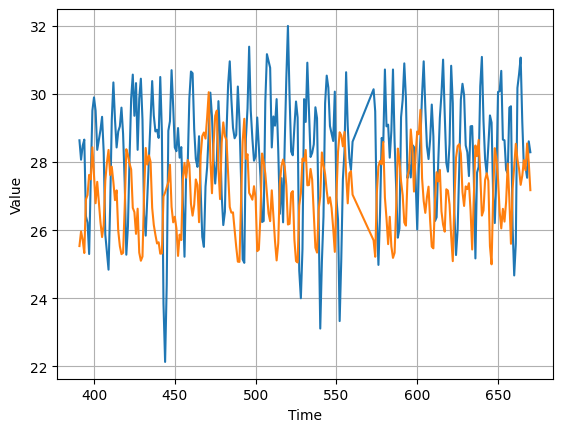

In [ ]:
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
len(time_valid)

267

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

7.343635
2.3194091


In [ ]:
model.save('./drive/MyDrive/timeseries_tuned.h5')

In [ ]:
model = tf.keras.models.load_model('./drive/MyDrive/timeseries_tuned.h5')

In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
